In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# load the dataset
df = pd.read_csv("FuelEconomy.xls")
df.describe()

print("Columns:", df.columns.tolist())
print("\nShape:", df.shape)

print("\nSummary statistics:")
display(df.describe(include="all"))

print("\nMissing values per column:")
display(df.isna().sum())

Columns: ['Horse Power', 'Fuel Economy (MPG)']

Shape: (100, 2)

Summary statistics:


,Horse Power,Fuel Economy (MPG)
count,100.000000,100.000000
mean,213.676190,23.178501
std,62.061726,4.701666
min,50.000000,10.000000
25%,174.996514,20.439516
50%,218.928402,23.143192
75%,251.706476,26.089933
max,350.000000,35.000000



Missing values per column:


Horse Power           0
Fuel Economy (MPG)    0
dtype: int64

In [3]:
# ============================================================
# Utility functions
# ============================================================

TARGET_COL = "Horse Power"
EXTRA_COL = ""

def prepare_xy(df_in, target_col=TARGET_COL):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y

def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names) from either:
       - LinearRegression
       - Pipeline(PolynomialFeatures -> LinearRegression)
    """
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name=TARGET_COL, top_k_terms=15):
    """Print a readable fitted equation.

    For polynomial models, the number of terms can become very large,
    so we print only the TOP-K terms by absolute coefficient magnitude.
    """
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    """Scatter plot of Actual vs Predicted values on the TEST set.

    We plot both series against a sample index, using:
    - Actual: blue circles
    - Predicted: red x's

    If test set is large, we randomly sample up to max_points points for readability.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

def run_models_and_evaluate(df_in, scenario_name, degrees=(1, 2, 3, 4),
                            target_col=TARGET_COL, test_size=0.30, random_state=42,
                            show_equation=True, show_plots=True, top_k_terms=15):
    """Train/evaluate linear (deg=1) + polynomial regression models.

    Returns a DataFrame of metrics.
    Also prints fitted equations and scatter plots (test set) for each model.
    """
    X, y = prepare_xy(df_in, target_col=target_col)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train)
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    return pd.DataFrame(rows)



Scenario: Fuel Consumption Prediction
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
Horse Power = 500.3638 (-12.3785) * Fuel Economy (MPG)


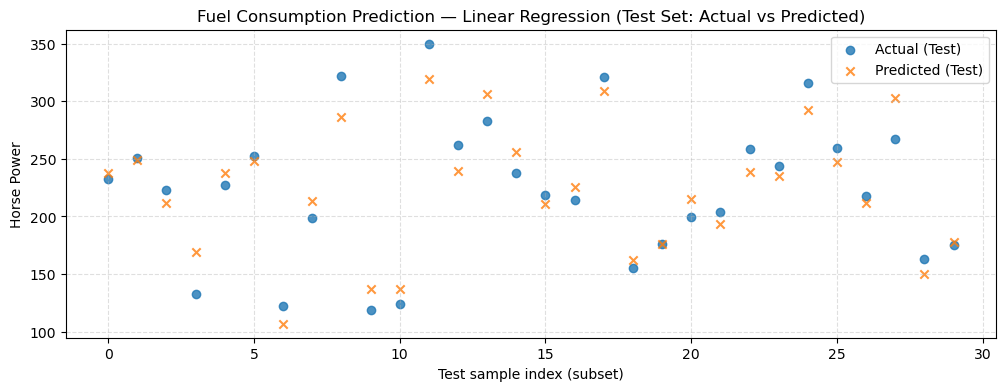


Scenario: Fuel Consumption Prediction
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 457.3741 (-8.5915) * Fuel Economy (MPG) (-0.0800) * Fuel Economy (MPG)^2


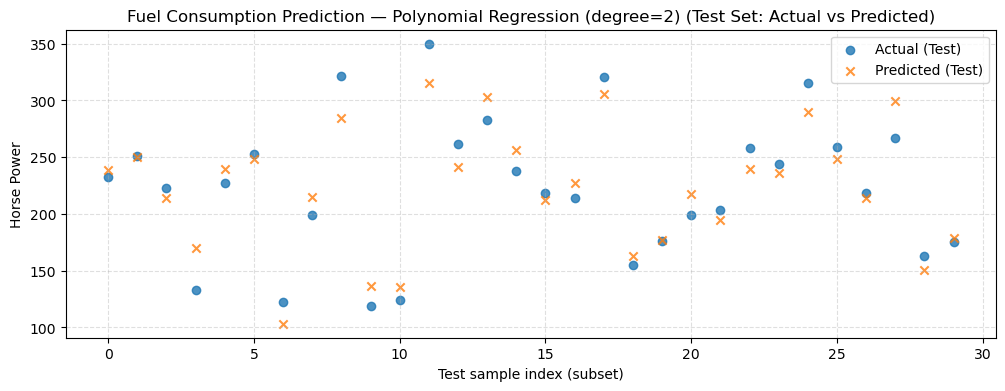


Scenario: Fuel Consumption Prediction
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 355.6514 (+6.0952) * Fuel Economy (MPG) (-0.7505) * Fuel Economy (MPG)^2 (+0.0097) * Fuel Economy (MPG)^3


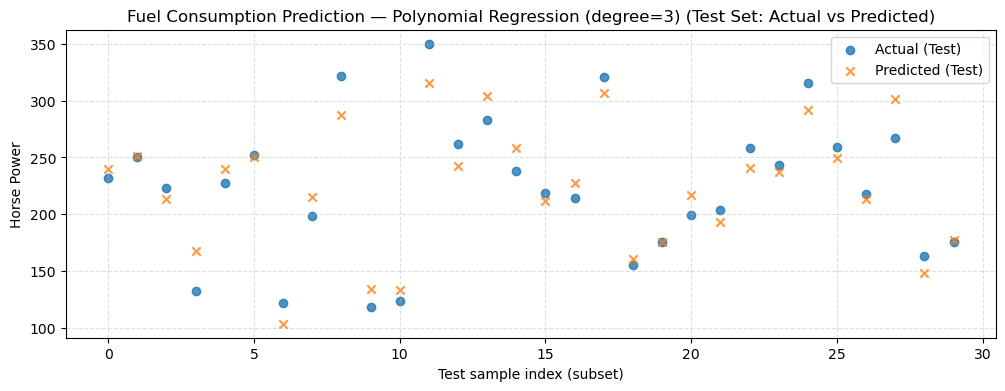


Scenario: Fuel Consumption Prediction
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 90.1049 (+61.1736) * Fuel Economy (MPG) (-4.7743) * Fuel Economy (MPG)^2 (+0.1339) * Fuel Economy (MPG)^3 (-0.0014) * Fuel Economy (MPG)^4


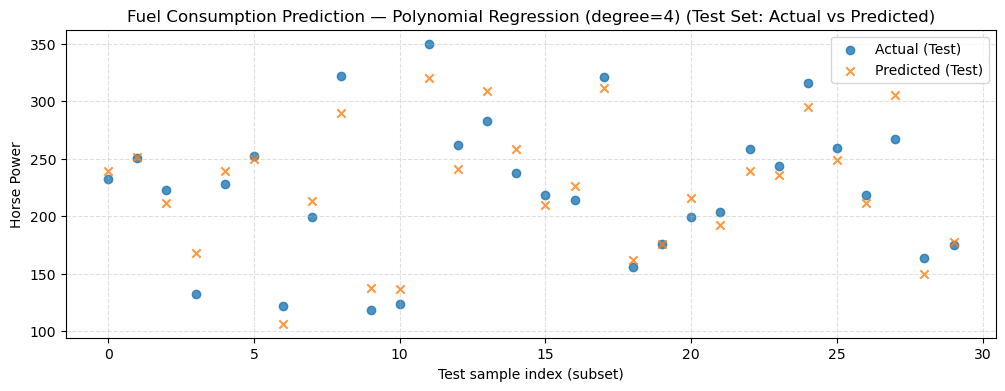

,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,Linear Regression,357.699180,16.061689,0.906320,318.561087,14.940628,0.912561,70,30
1,Polynomial Regression (degree=2),350.879731,15.995824,0.908106,331.105434,15.148330,0.909118,70,30
2,Polynomial Regression (degree=3),345.108668,15.746762,0.909618,318.404012,14.764973,0.912604,70,30
3,Polynomial Regression (degree=4),339.700171,15.508465,0.911034,313.798757,14.735471,0.913868,70,30


In [4]:
# Data preparation
df_clean = df.dropna().copy()
X = df_clean.drop(columns=["Horse Power"])
y = df_clean["Horse Power"]

# 70/30 random train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

results_A = run_models_and_evaluate(
    df_clean,
    scenario_name="Fuel Consumption Prediction",
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

display(results_A)

Use your results to answer the following questions with a data-driven explanation:
- Which model performs best on the test set and why?
    - ANSWER: The 4th degree polynomial regression model performs best on the test set because it has the highest R^2 value and the lowest MSE and MAE out of all the models. The next best model is the 3rd degree polynomial regression model, then linear regression, and then the 2nd degree polynomial regression model.
- Does increasing polynomial degree always improve performance? If not, explain what you observe.
    - ANSWER: No, as previously stated the order for the best model is not ordered by the number of degrees since linear regression performs better than the 2nd degree polynomial regression model.
- If a model performs unexpectedly poorly (e.g., low R2 or large test error), propose at least two
plausible reasons, such as:
    - underfitting vs overfitting,
    - weak relationship between features and target,
    - outliers or noise in the data,
    - insufficient feature information for predicting HP.
- ANSWER: I don't think there is a weak relationship between features and target because of the high R^2 value there is for linear regression. I think there is noise in the data because there are certain inputs that have different actual outputs. I think there is insufficient feature information for predicting HP because when one looks at the defining equation for each regression model, the higher degree coefficients are statistically less significant than the first degree coefficients.
- Support your claims using your reported metrics (not intuition only).

In [5]:
# ============================================================
# Utility functions
# ============================================================

TARGET_COL = "daily_consumption"
EXTRA_COL = "date"

def prepare_xy(df_in, target_col=TARGET_COL):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y

def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names) from either:
       - LinearRegression
       - Pipeline(PolynomialFeatures -> LinearRegression)
    """
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name=TARGET_COL, top_k_terms=15):
    """Print a readable fitted equation.

    For polynomial models, the number of terms can become very large,
    so we print only the TOP-K terms by absolute coefficient magnitude.
    """
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    """Scatter plot of Actual vs Predicted values on the TEST set.

    We plot both series against a sample index, using:
    - Actual: blue circles
    - Predicted: red x's

    If test set is large, we randomly sample up to max_points points for readability.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

def run_models_and_evaluate(df_in, scenario_name, degrees=(1, 2, 3, 4),
                            target_col=TARGET_COL, test_size=0.30, random_state=42,
                            show_equation=True, show_plots=True, top_k_terms=15):
    """Train/evaluate linear (deg=1) + polynomial regression models.

    Returns a DataFrame of metrics.
    Also prints fitted equations and scatter plots (test set) for each model.
    """
    X, y = prepare_xy(df_in, target_col=target_col)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train)
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    return pd.DataFrame(rows)


In [ ]:
# Data preparation
df2 = pd.read_csv("electricity_consumption_based_weather_dataset.csv")
df2 = df2.drop(columns=[EXTRA_COL]).copy()
df2.describe()

print("Columns:", df2.columns.tolist())
print("\nShape:", df2.shape)
print("\nSummary statistics:")
display(df2.describe(include="all"))

print("\nMissing values per column:")
display(df2.isna().sum())

df2 = df2.dropna()

df2.describe()

print("Columns:", df2.columns.tolist())
print("\nShape:", df2.shape)
print("\nSummary statistics:")
display(df2.describe(include="all"))

print("\nMissing values per column:")
display(df2.isna().sum())

Columns: ['AWND', 'PRCP', 'TMAX', 'TMIN', 'daily_consumption']

Shape: (1433, 5)

Summary statistics:


,AWND,PRCP,TMAX,TMIN,daily_consumption
count,1418.000000,1433.000000,1433.000000,1433.000000,1433.000000
mean,2.642313,3.800488,17.187509,9.141242,1561.078061
std,1.140021,10.973436,10.136415,9.028417,606.819667
min,0.000000,0.000000,-8.900000,-14.400000,14.218000
25%,1.800000,0.000000,8.900000,2.200000,1165.700000
50%,2.400000,0.000000,17.800000,9.400000,1542.650000
75%,3.300000,1.300000,26.100000,17.200000,1893.608000
max,10.200000,192.300000,39.400000,27.200000,4773.386000



Missing values per column:


AWND                 15
PRCP                  0
TMAX                  0
TMIN                  0
daily_consumption     0
dtype: int64

Columns: ['AWND', 'PRCP', 'TMAX', 'TMIN', 'daily_consumption']

Shape: (1418, 5)

Summary statistics:


,AWND,PRCP,TMAX,TMIN,daily_consumption
count,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000
mean,2.642313,3.734274,17.132722,9.085825,1562.330257
std,1.140021,10.864197,10.155059,9.044534,608.175083
min,0.000000,0.000000,-8.900000,-14.400000,14.218000
25%,1.800000,0.000000,8.900000,2.200000,1164.759500
50%,2.400000,0.000000,17.800000,9.400000,1544.028000
75%,3.300000,1.300000,26.100000,17.200000,1894.467500
max,10.200000,192.300000,39.400000,27.200000,4773.386000



Missing values per column:


AWND                 0
PRCP                 0
TMAX                 0
TMIN                 0
daily_consumption    0
dtype: int64


Scenario: Electricity Consumption Prediction
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2045.7562 (-17.2734) * TMAX (-17.0839) * TMIN (-7.5783) * AWND (-3.3603) * PRCP


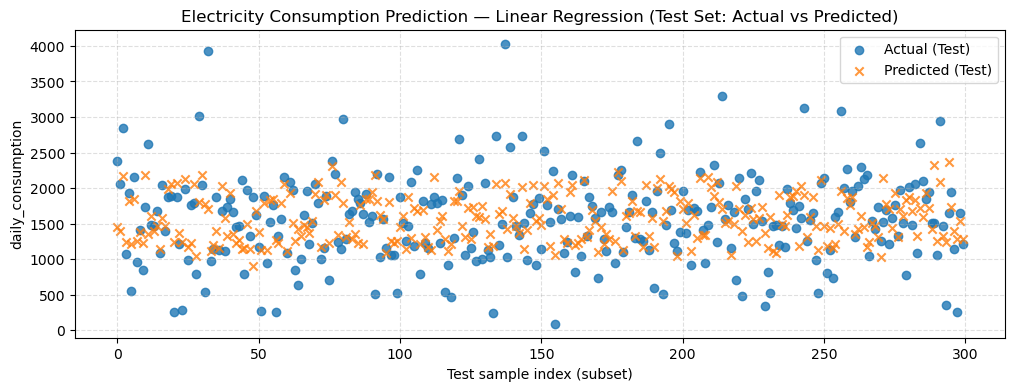


Scenario: Electricity Consumption Prediction
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2037.4142 (+165.5267) * AWND (-60.9740) * TMAX (-27.8962) * AWND^2 (+26.8325) * TMIN (-10.4820) * PRCP (-2.6130) * TMAX TMIN (-1.9368) * PRCP TMIN (+1.8505) * TMAX^2 (+1.5725) * PRCP TMAX (+1.2309) * AWND PRCP (+1.1693) * AWND TMIN (-1.0760) * AWND TMAX (+0.2939) * TMIN^2 (-0.0545) * PRCP^2


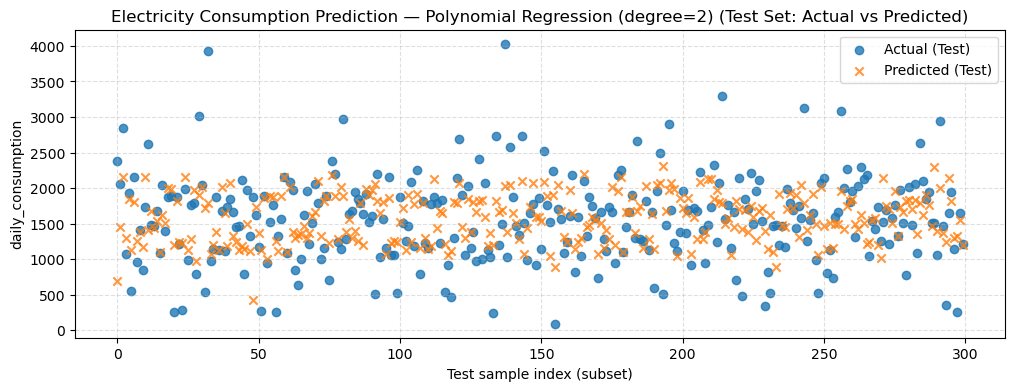


Scenario: Electricity Consumption Prediction
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 1405.7630 (+509.9634) * AWND (-140.8094) * AWND^2 (+67.4216) * TMAX (-63.7983) * TMIN (+25.0565) * TMAX TMIN (-20.2281) * AWND TMIN (-13.9648) * TMIN^2 (-13.1044) * TMAX^2 (+9.3010) * PRCP (+7.8406) * AWND^3 (-4.9294) * AWND PRCP (+3.8559) * AWND^2 TMAX (+3.4853) * AWND TMAX TMIN (+2.2711) * AWND TMAX (-1.8669) * TMAX^2 TMIN
(Showing top 15 terms out of 34 total terms.)


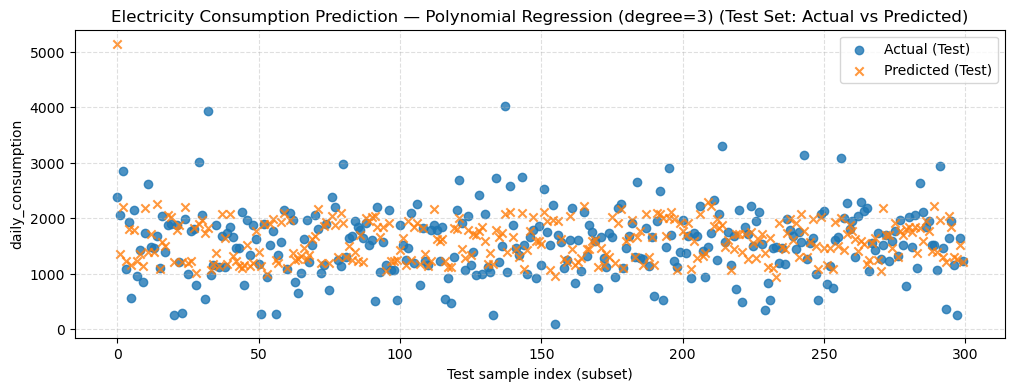


Scenario: Electricity Consumption Prediction
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 1437.2413 (-416.4509) * AWND (-386.5721) * TMIN (+312.1157) * TMAX (+245.1996) * AWND^2 (+175.5947) * TMAX TMIN (+144.1717) * AWND TMAX (-110.1963) * AWND TMIN (-89.7729) * TMIN^2 (-83.0902) * AWND PRCP (-82.3475) * TMAX^2 (-63.0753) * AWND^2 TMAX (+58.6639) * AWND^2 TMIN (-41.9050) * AWND^3 (+26.1746) * AWND^2 PRCP (-25.1428) * AWND TMAX TMIN
(Showing top 15 terms out of 69 total terms.)


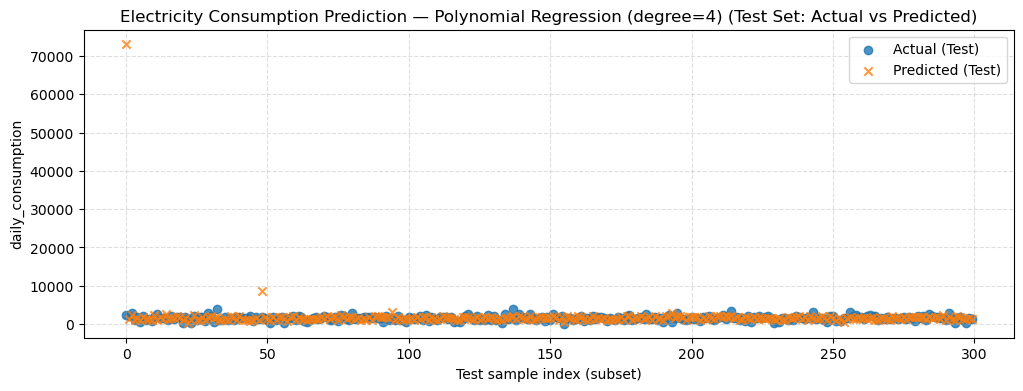

,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,Linear Regression,272403.396174,384.465016,0.276000,2.481258e+05,375.404537,0.299333,992,426
1,Polynomial Regression (degree=2),264765.769932,379.648753,0.296300,2.552685e+05,379.039083,0.279163,992,426
2,Polynomial Regression (degree=3),259249.534870,375.952901,0.310961,2.656237e+05,385.235167,0.249922,992,426
3,Polynomial Regression (degree=4),251909.339001,372.116566,0.330470,1.215149e+07,578.642201,-33.313844,992,426


In [7]:
# Data preparation
df2_clean = df2.dropna().copy()
X = df2_clean.drop(columns=["daily_consumption"])
y = df2_clean["daily_consumption"]

# 70/30 random train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

results_A = run_models_and_evaluate(
    df2_clean,
    scenario_name="Electricity Consumption Prediction",
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

display(results_A)

- Which model generalizes best (best test performance), and what does that tell you about the
relationship between weather and electricity usage?
    - All the different models perform horribly. The best one is the simplest, Linear regression because it has the highest R^2 value and lowest MSE and MAE values.
- Do polynomial models improve the fit compared to linear regression? If yes, why might electricity
consumption have nonlinear dependence on weather?
    - Definitely not, increasing the degree decreases the model reliability.
- If higher-degree models perform worse on the test set, explain this behavior using evidence from
metrics (e.g., train error decreases but test error increases).
    - Higher-degree models perform worse on the test set because as the degree increases, the test R^2 decreases. Eventually it becomes negative for the 4th degree polynomial regression model.
- If none of the models achieve good test performance, provide at least two reasons supported by
your outputs (e.g., limited feature set, high noise, unmodeled drivers such as occupancy/behavior,
seasonal effects).
    - It seems that the model is underfitting for all cases because even the training R^2 is extremely low if we want high reliability. This is most likely due to the fact that the independent variables do not play a large part in determining the daily consumption amount, therefore having a larger feature set would perhaps improve the reliability. I would also assume that classifying the data for each season would yield more reliable daily consumption results because it decreasess the unexplained variability (which directly impacts the calculation of R^2).